# Homework 11
## Mengxiang Jiang

The majority of the code here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 11.
If the code comes from somewhere else it will have a source linked to the original.\
[Video Link](https://youtu.be/3stHd7w4hD0)

### Preparing the IMDB movie reviews data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

In [1]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Displaying the shapes and dtypes of the first batch**

In [2]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'With this movie only running 61 minutes and nothing all that good on television, I decided to pop Revolt of the Zombies into the DVD to pass the time. Even while realizing the era from which it was coming, I was sorely disappointed. It started with the oddly upbeat quality of the opening score (what - no brooding music?) and then the rather slow moving opening sequences. Gosh, I figured a movie about zombies - even from the 1930s - would have SOME chills to it (White Zombie, with Bela Lugosi, certainly did) but this had none. Zero. It was scarcely even dramatic (except for the few moments with the burning eyes superimposed on the film to indicate the mesmerization of someone). Like the equally dull King of the Zombies, this movie may be an interesting curiosity to own, but nothing more.', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


### Processing words as a set: The bag-of-words approach

### Experiment 1: Binary Bigram Model

**Configuring the `TextVectorization` layer to return bigrams**

In [3]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

**Model-building utility**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary bigram model**

In [5]:
text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "binary_2gram.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]
history = model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=50,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
____________________________________________________

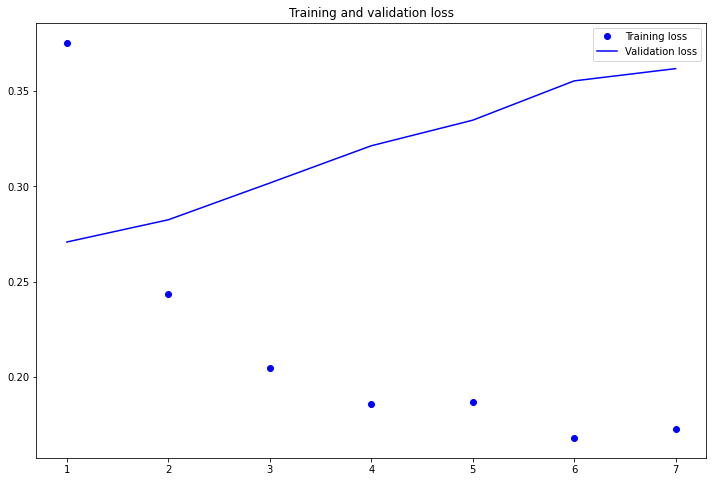

In [6]:
from matplotlib import pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

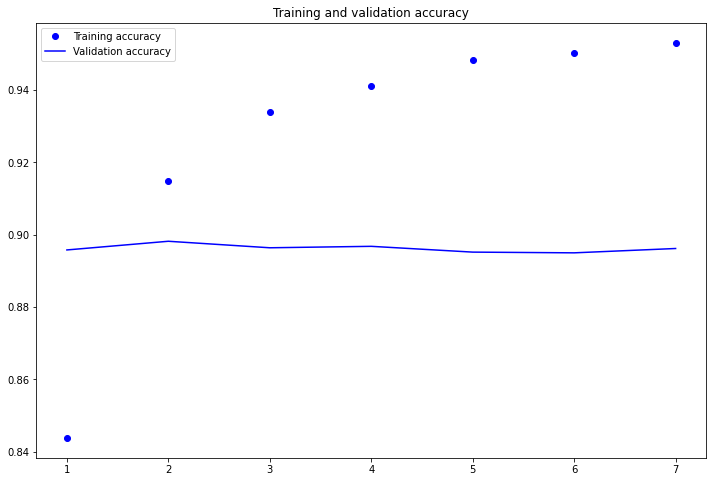

In [7]:
epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

### Experiment 2: Embedding layer with masking

**Preparing integer sequence datasets**

In [8]:
max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Understanding padding and masking
**Using an `Embedding` layer with masking enabled**

In [14]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "embeddings_bidir_lstm_with_masking.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_lstm_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

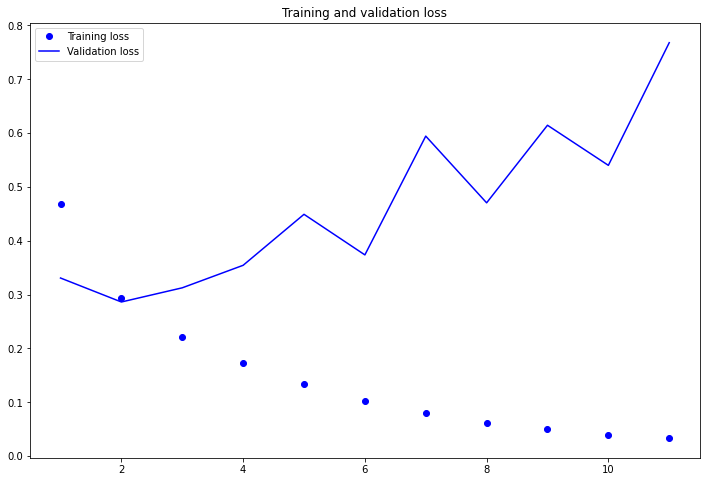

In [15]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

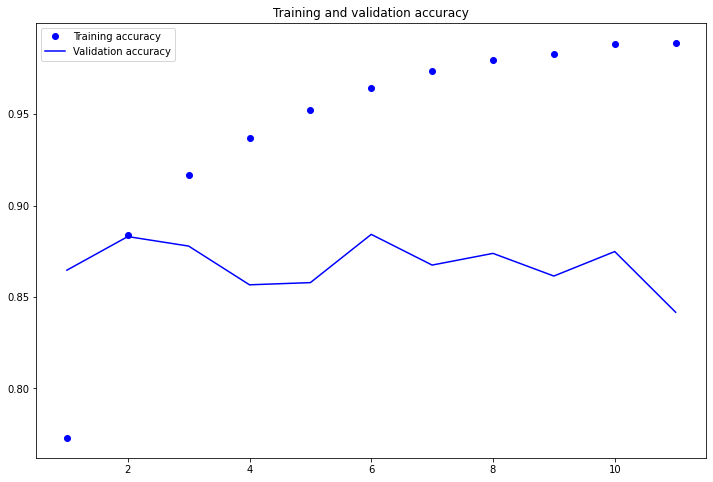

In [16]:
epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

### Experiment 3: Use pretrained embedding layer

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-15 15:45:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-15 15:45:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-15 15:45:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [17]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [18]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [20]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "glove_embeddings_sequence_model.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

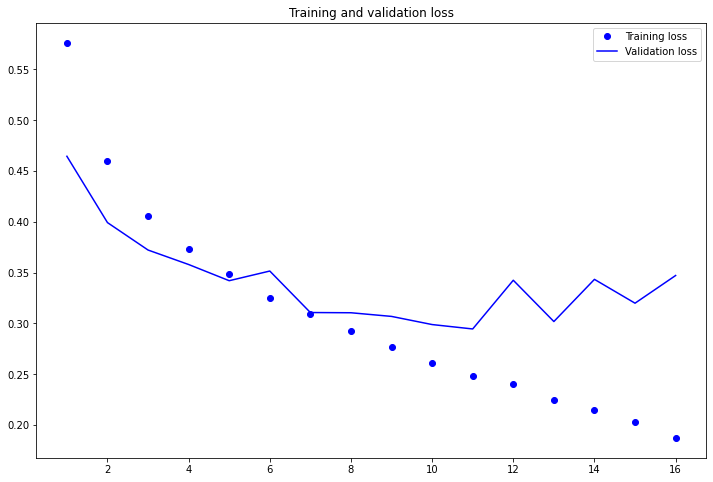

In [21]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

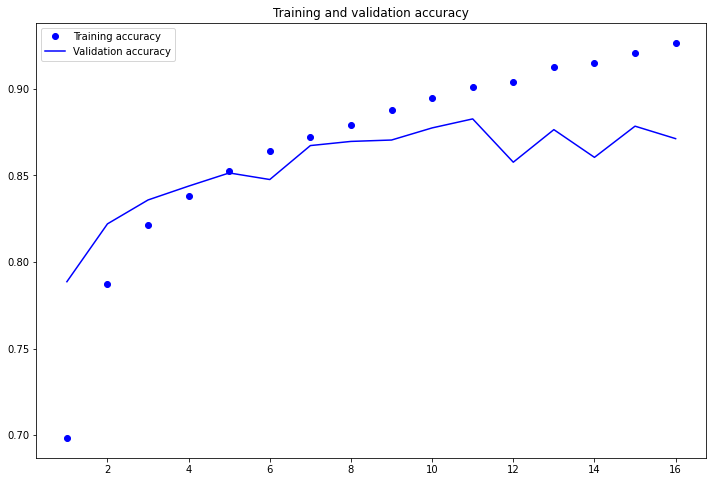

In [22]:
epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

### Comparisons between the 3 experiments

In [25]:
model_bigram = keras.models.load_model("binary_2gram.keras")
bigram_train_acc = model_bigram.evaluate(binary_2gram_train_ds)[1]
bigram_val_acc = model_bigram.evaluate(binary_2gram_val_ds)[1]
bigram_test_acc = model_bigram.evaluate(binary_2gram_test_ds)[1]

model_embed = keras.models.load_model("embeddings_bidir_lstm_with_masking.keras")
embed_train_acc = model_embed.evaluate(int_train_ds)[1]
embed_val_acc = model_embed.evaluate(int_val_ds)[1]
embed_test_acc = model_embed.evaluate(int_test_ds)[1]

model_glove = keras.models.load_model("glove_embeddings_sequence_model.keras")
glove_train_acc = model_glove.evaluate(int_train_ds)[1]
glove_val_acc = model_glove.evaluate(int_val_ds)[1]
glove_test_acc = model_glove.evaluate(int_test_ds)[1]

782/782 [==============================] - 8s 10ms/step - loss: 0.2871 - accuracy: 0.8798


**Adapted from geeks for geeks bar chart example [code](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/#)**

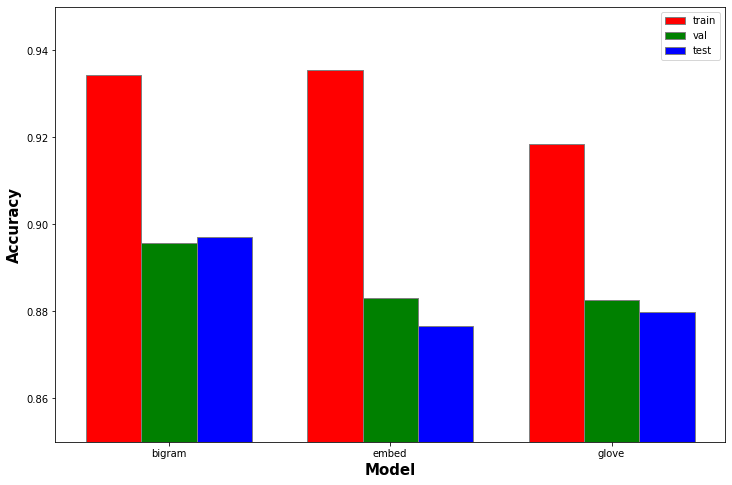

In [31]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
train_acc = [bigram_train_acc, embed_train_acc, glove_train_acc]
val_acc = [bigram_val_acc, embed_val_acc, glove_val_acc]
test_acc = [bigram_test_acc, embed_test_acc, glove_test_acc]
 
# Set position of bar on X axis
br1 = np.arange(len(train_acc))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, train_acc, color ='r', width = barWidth,
        edgecolor ='grey', label ='train')
plt.bar(br2, val_acc, color ='g', width = barWidth,
        edgecolor ='grey', label ='val')
plt.bar(br3, test_acc, color ='b', width = barWidth,
        edgecolor ='grey', label ='test')

plt.ylim(0.85, 0.95) 

# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_acc))],
        ['bigram', 'embed', 'glove'])
 
plt.legend()
plt.show()